In [31]:
import requests
import sys
import os
from PIL import Image
from io import BytesIO
from paddleocr import draw_ocr
import matplotlib.pyplot as plt

In [14]:
sys.path.append(os.path.abspath("../jobs"))

In [15]:
from sample_generation.image_utils import denormalise_box_coordinates

### Push Sample to Server

In [4]:
sample_id = 1
document_id = 5

In [21]:
image_path = f"../data/sampling/document_{document_id}/sample_{sample_id}.png"

In [20]:
url = "http://localhost:8000/document_generator/api/sample_documents/"
files = {
    "image": open(image_path, "rb")
}
data = {
    "name": f"sample_{sample_id}",
    "template_document": document_id
}

with requests.Session() as session:
    response = session.post(url, files=files, data=data)

NameError: name 'image_path' is not defined

In [9]:
response.json()

{'id': 3,
 'name': 'sample_1',
 'image': 'http://localhost:8000/media/document_samples/sample_0_WnvVe1D.png',
 'template_document': 1}

### Read Sample from Server

In [58]:
document_id = 5

In [59]:
get_samples_url = f"http://localhost:8000/document_generator/api/documents/{document_id}/get_samples/"

with requests.Session() as session:
    res_samples = session.get(get_samples_url)

if res_samples.status_code != 200:
    raise ValueError(f"cannot retrieve samples for document: {document_id}")
else:
    samples = res_samples.json()

In [60]:
sample = samples[0]
sample

{'id': 1302,
 'name': 'sample_9',
 'image': '/media/document_samples/sample_9_tOkvZvh.png',
 'template_document': 5}

In [61]:
sample_id = sample["id"]

In [62]:
with requests.Session() as session:
    res_image = session.get("http://localhost:8000/" + sample["image"])

if res_image.status_code == 200:
    sample_image = Image.open(BytesIO(res_image.content))
else:
    raise ValueError(f"could not retrieve the image error: {res_image.status_code}")

In [63]:
get_sample_boxes_url = f"http://localhost:8000/document_generator/api/sample_documents/{sample_id}/get_boxes/"

with requests.Session() as session:
    res_boxes = session.get(get_sample_boxes_url)

if res_boxes.status_code != 200:
    raise ValueError(f"cannot retrieve boxes for sample: {sample_id}")
else:
    boxes = res_boxes.json()

In [64]:
boxes

[{'id': 2366,
  'name': 'cognome',
  'label': 'PCITRWV',
  'start_x_norm': 0.1536231884057971,
  'start_y_norm': 0.16990291262135923,
  'end_x_norm': 0.26956521739130435,
  'end_y_norm': 0.18543689320388348,
  'sample_document': 1302,
  'template_box': 18},
 {'id': 2367,
  'name': 'cognome_b',
  'label': 'YVCQDUXOB',
  'start_x_norm': 0.7768115942028986,
  'start_y_norm': 0.1650485436893204,
  'end_x_norm': 0.9521739130434783,
  'end_y_norm': 0.18349514563106797,
  'sample_document': 1302,
  'template_box': 19}]

In [65]:
doc_width = sample_image.width
doc_height = sample_image.height

In [66]:
box_coords = []

for box in boxes:
    start_x, start_y, end_x, end_y = denormalise_box_coordinates(box["start_x_norm"], box["start_y_norm"], 
                                                                 box["end_x_norm"], box["end_y_norm"],
                                                                 doc_width=doc_width, doc_height=doc_height)

    box_coords.append([[start_x, start_y], [end_x, start_y], [end_x, end_y], [start_x, end_y]])

In [67]:
box_coords

[[[106, 175], [186, 175], [186, 191], [106, 191]],
 [[536, 170], [657, 170], [657, 189], [536, 189]]]

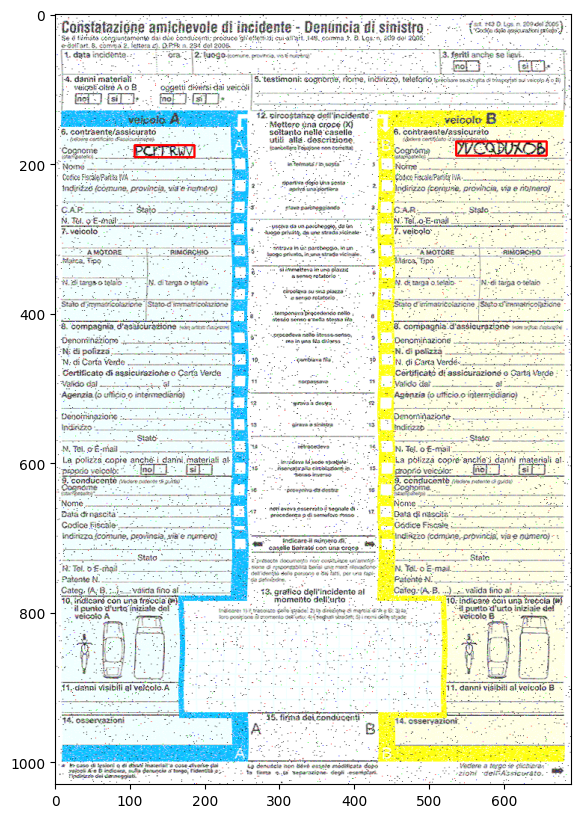

In [68]:
plt.figure(figsize=(20, 10))
plt.imshow(draw_ocr(sample_image, box_coords))
plt.show()